In [3]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betatcvae import BetaTCVAE, compile_vae, weights
from optimize_utils_tcvae import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [4]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [6]:
# Load the best hyperparameters
study_name = "BetaTCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [7]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 194.21174954086987, Val Loss: 55.545081244574654, Test Loss: 55.857671949598526
Epoch 2, Train Loss: 33.08318167159806, Val Loss: 50.255775451660156, Test Loss: 50.87712097167969
Epoch 3, Train Loss: 36.50734489782533, Val Loss: 47.25805155436198, Test Loss: 47.94995371500651
Epoch 4, Train Loss: 39.304254514779615, Val Loss: 48.01293521457248, Test Loss: 48.125177171495224
Epoch 5, Train Loss: 42.02563859170942, Val Loss: 42.16968663533529, Test Loss: 43.26887554592557
Epoch 6, Train Loss: 42.62351137986823, Val Loss: 41.029533810085724, Test Loss: 41.834283192952476
Epoch 7, Train Loss: 41.178604262622436, Val Loss: 40.04288652208116, Test Loss: 40.887438456217446
Epoch 8, Train Loss: 40.78212808637477, Val Loss: 40.93491999308268, Test Loss: 41.3560545179579
Epoch 9, Train Loss: 40.49007185750933, Val Loss: 39.02787356906467, Test Loss: 40.15389633178711
Epoch 10, Train Loss: 38.78491119840252, Val Loss: 42.436364067925346, Test Loss: 43.06593704223633
Epoch 11,

In [8]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [9]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the CSV file
history_path = pathlib.Path("results/tc_training_history.csv")

# Save the DataFrame to a CSV file
history_df.to_csv(history_path, index=False)

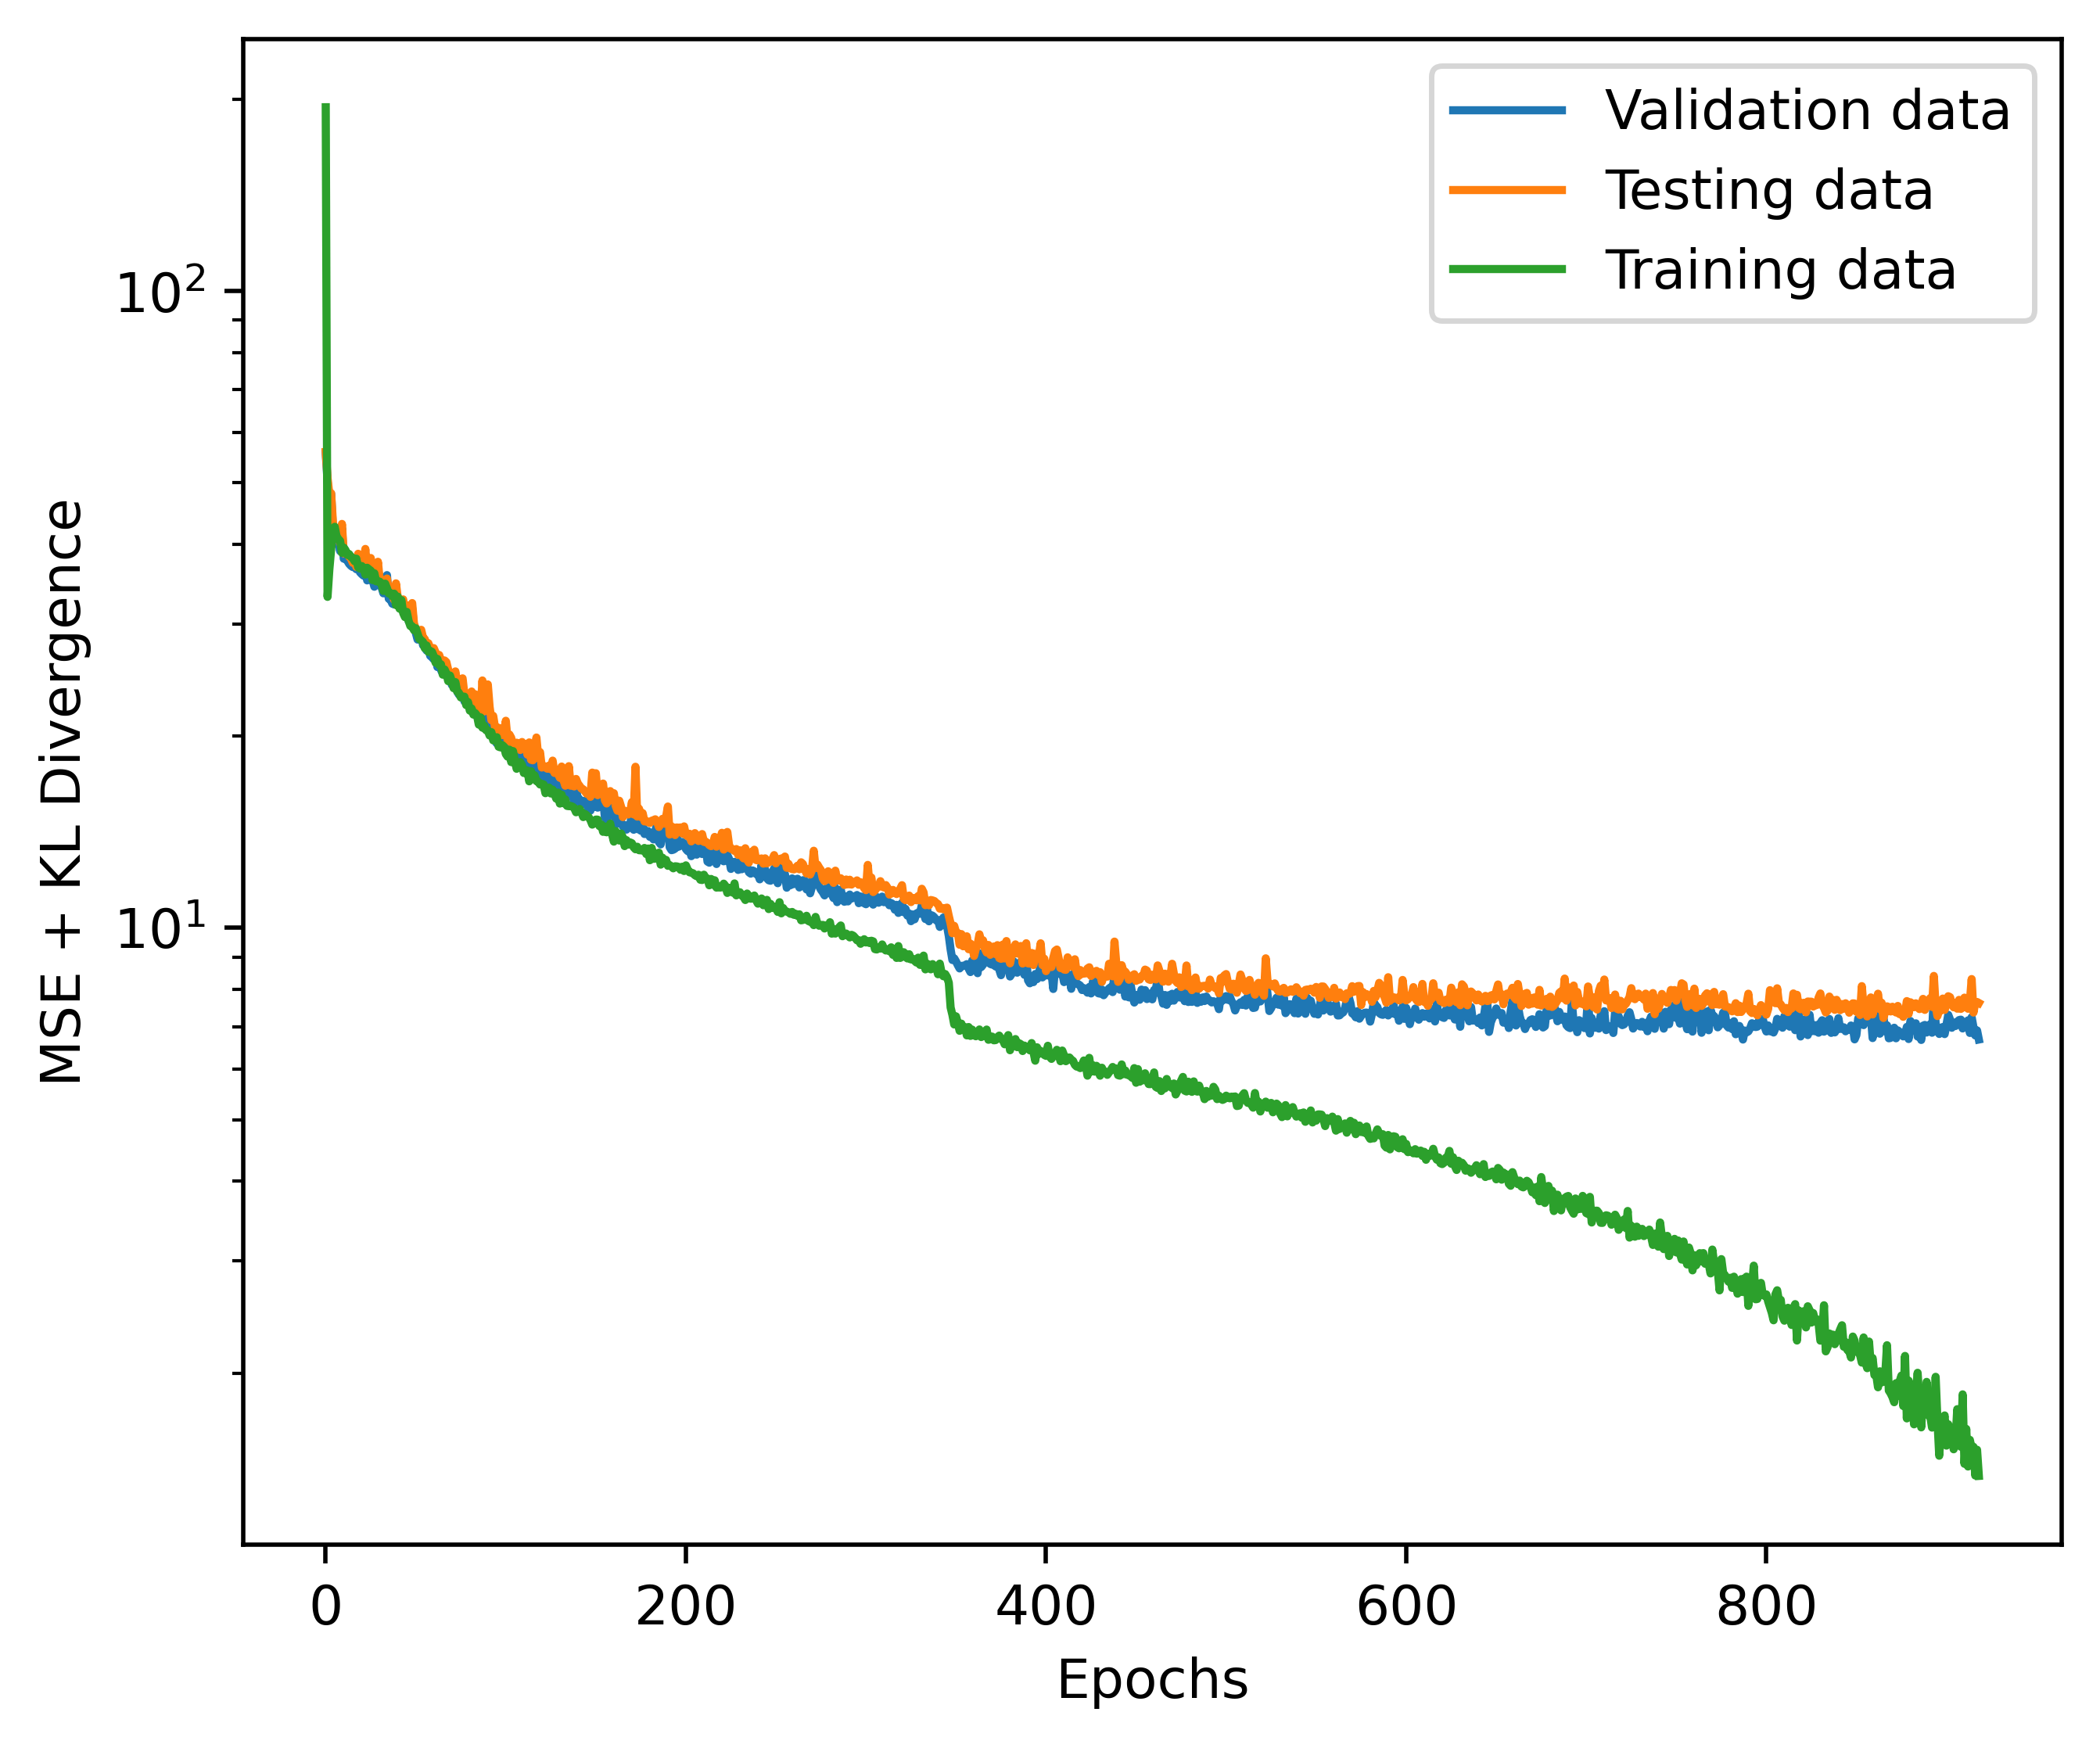

In [10]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

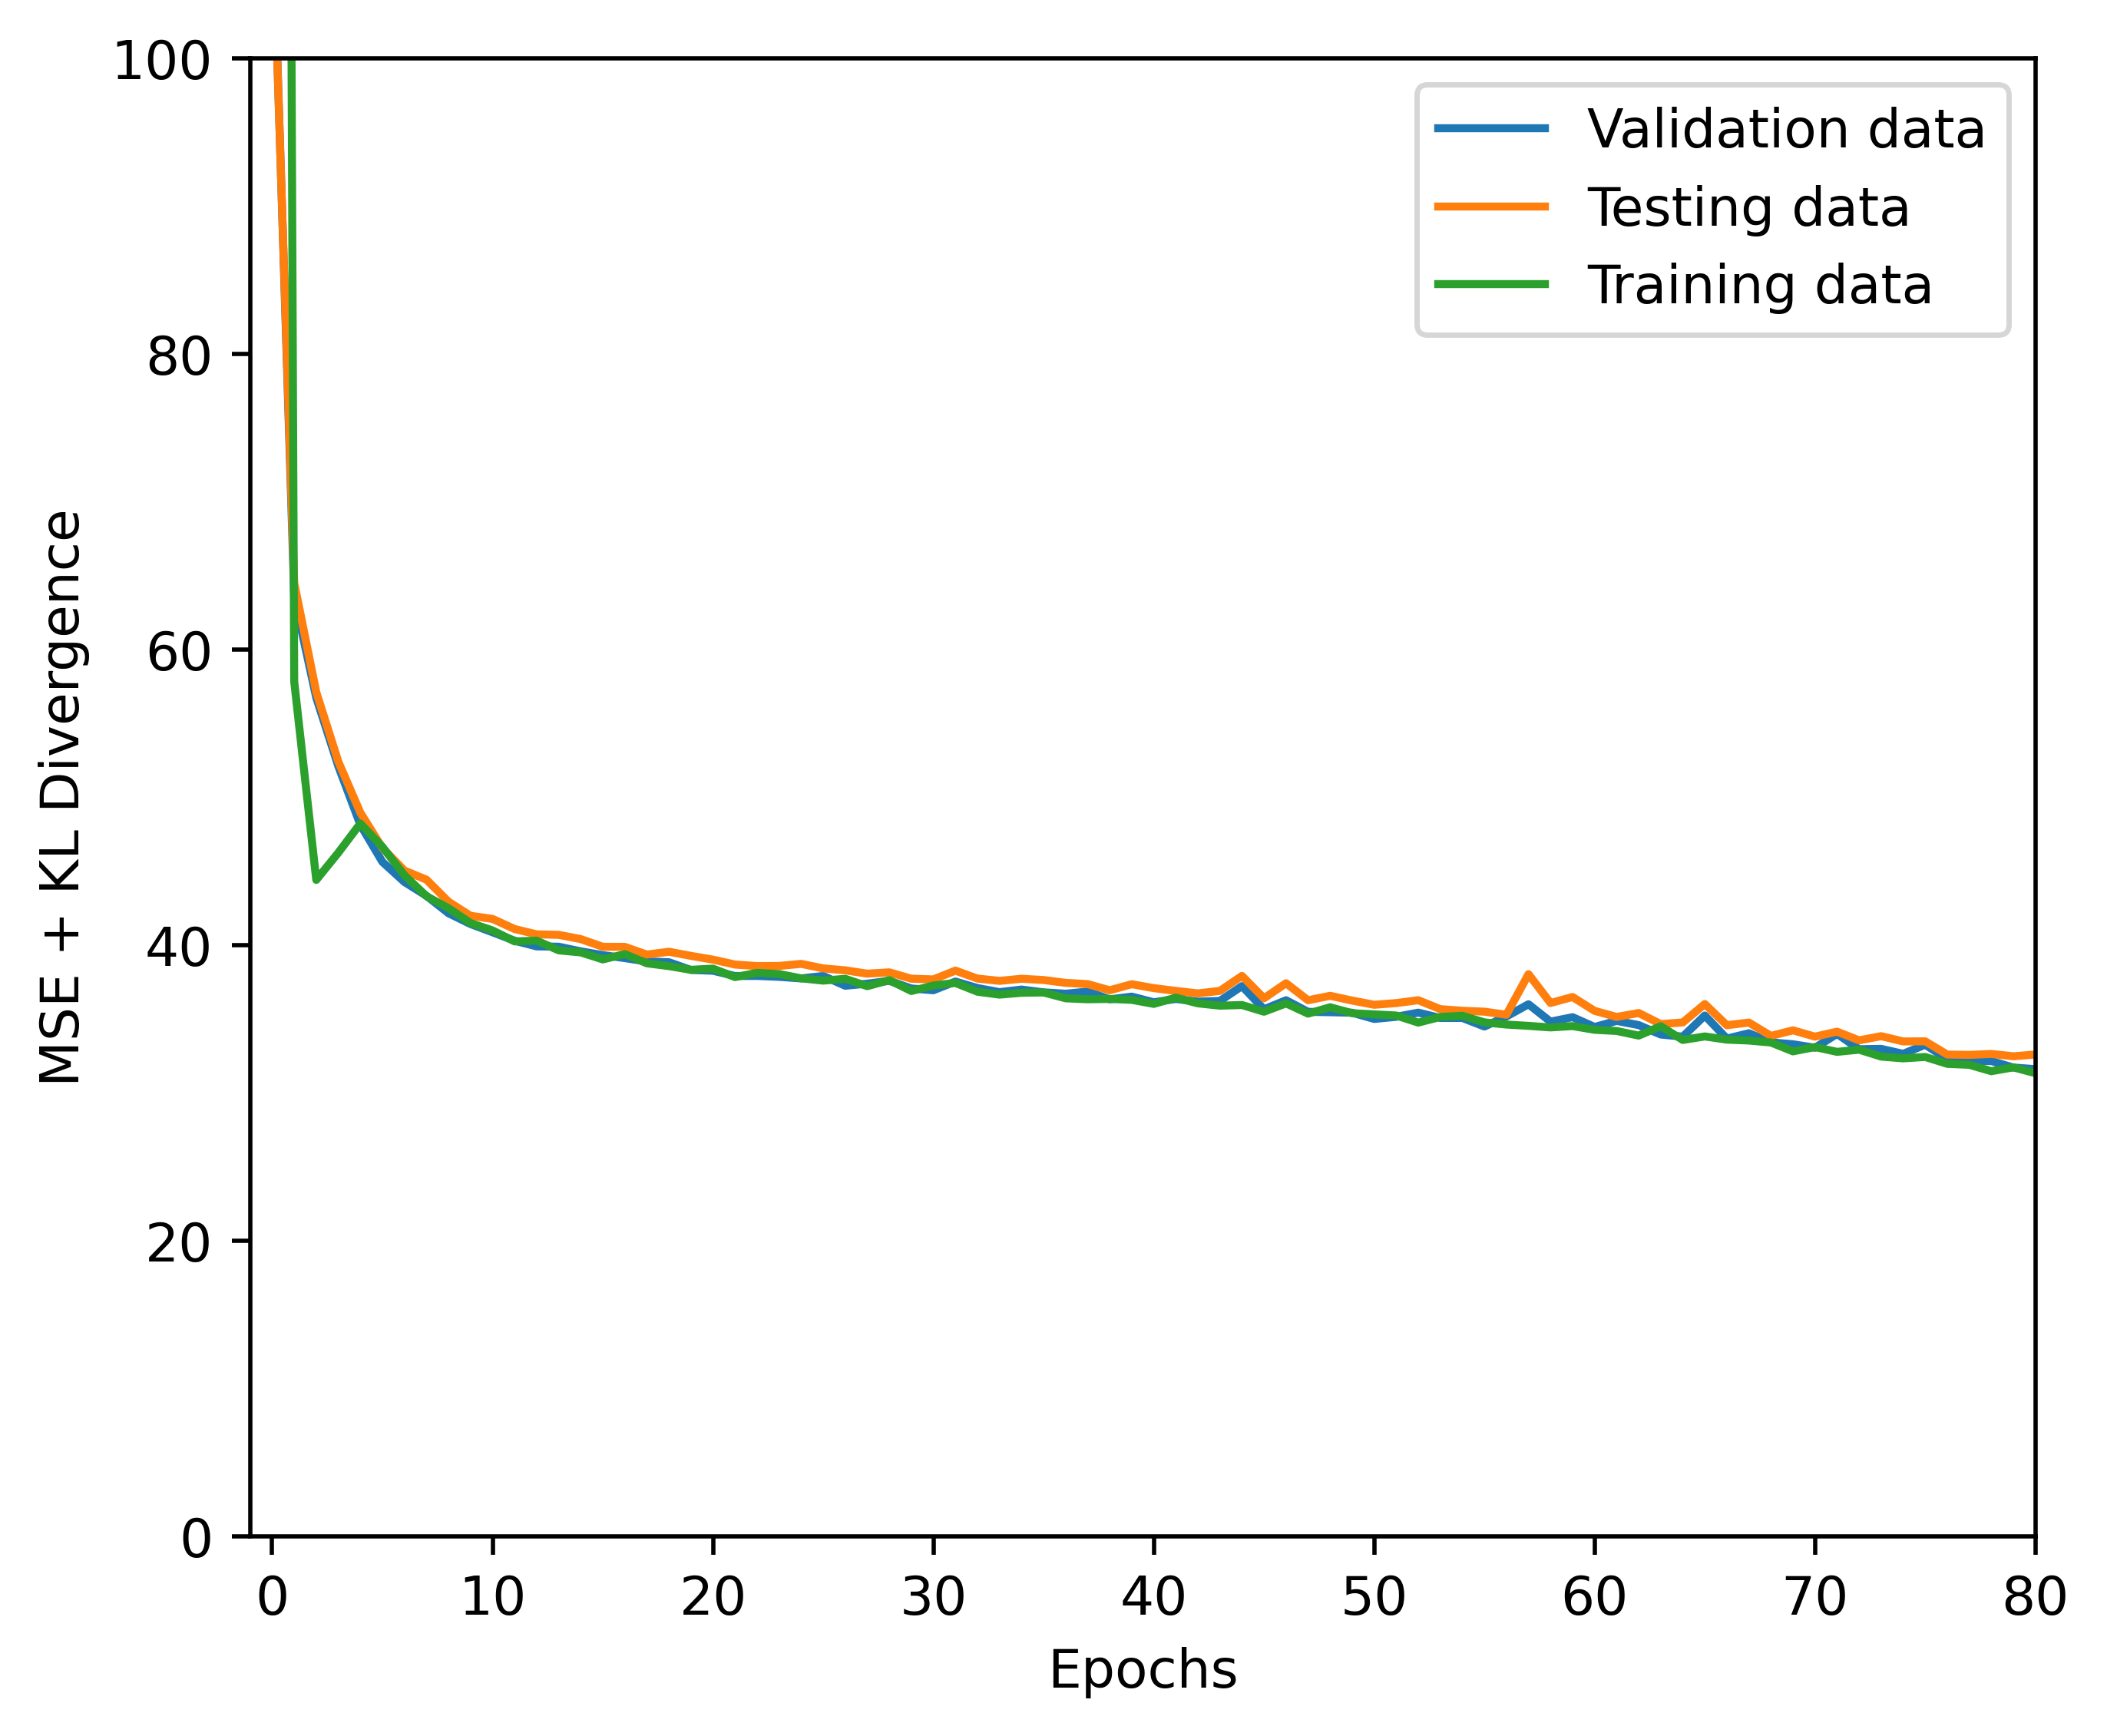

In [ ]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [ ]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea_tc.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data, path)